# Home prices and foreclosures

Many American's don't have much equity outside of their home when they retire -- that is much of their equity is their house http://www.epi.org/publication/retirement-in-america/. As a measure of personal wealth, we will pull in housing prices per square foot, as well as seeing home foreclosures in Chicago. 

Zillow has generously made their measurements of these over 20 years freely available. The approach here is to pull in their data and map it to the Chicago Data Portal neighborhoods. Zillow publishes this data by zip code and by their own neighborhood conventions. We will take the Zillow neighborhoods and map them to Chicago Data Portal neighborhoods by looking at the intersections of the regions.

Zillow's foreclosures data was a little spotty and therefore we had to use an alternative source (De Paul Institute for Housing Studies)

Zillow data sources:
* Zillow real estate data: https://www.zillow.com/research/data/
* Zillow geographical boundary data: https://www.zillow.com/howto/api/neighborhood-boundaries.htm

Institute for housing studies:
* Foreclosures by neighborhood by year: https://www.housingstudies.org/dataportal/filings/foreclosures-100-residential-parcel/chicago-community-areas/2005/2016/#

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Home foreclosures from the Institute for Housing Studies

Below we capture the foreclosure rates by neighborhood from 2005-2016. This data was made freely available from the De Paul Instutite for Housing Studies. The data needs a little cleaning / formatting to put into a proper annual timeseries, but otherwise is relatively straightforward.

In [2]:
ifhs_foreclosues = pd.read_csv('./data/foreclosure_data_community_area.csv')
ifhs_foreclosues.columns = ['community', 'community_num'] + [ int(col.split('_')[2]) for col in ifhs_foreclosues.columns[2:]]
ifhs_foreclosues['community'] = ifhs_foreclosues['community'].str.upper()
ifhs_foreclosues.head()

,community,community_num,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,CITY OF CHICAGO TOTAL,NaN,1.1,1.5,2.2,2.9,3.0,3.0,2.4,2.4,1.6,1.1,0.9,0.9
1,ALBANY PARK,14.0,0.4,0.7,1.7,2.9,4.0,4.3,3.0,2.6,1.5,0.7,0.7,0.5
2,ARCHER HEIGHTS,57.0,0.7,1.2,1.5,3.4,4.0,4.5,3.4,2.9,1.6,1.2,1.1,0.7
3,ARMOUR SQUARE,34.0,0.2,0.2,0.2,0.2,0.3,0.7,0.4,0.8,0.5,0.2,0.1,0.2
4,ASHBURN,70.0,2.0,2.3,2.8,4.2,4.2,5.0,4.1,4.8,3.1,2.1,1.7,1.6


How do the names compare to our neighborhood names? The names in the Chicago Data Portal are all upper case, which is why we transformed accordingly above. We find that everything matches except for the City of Chicago aggregate (i.e. that doesn't exist in the other namebase) and O'Hare. Since it's one-off, we will handle it on the spot.

In [3]:
cdp_names = gpd.read_file('./data/chicago_commarea_geo_data.json')['community']
ifhs_names_not_in_cdp = [ (idx, ifhs_foreclosues['community'][idx]) for idx in ifhs_foreclosues.index\
                             if ifhs_foreclosues['community'][idx] not in cdp_names.values ]
print('names not properly mapped:', ifhs_names_not_in_cdp)

names not properly mapped: [(0, 'CITY OF CHICAGO TOTAL'), (56, "O'HARE")]


In [4]:
ifhs_foreclosues.set_value(ifhs_names_not_in_cdp[1][0], 'community', 'OHARE')
ifhs_names_not_in_cdp_post_fix = [ (idx, ifhs_foreclosues['community'][idx]) for idx in ifhs_foreclosues.index\
                             if ifhs_foreclosues['community'][idx] not in cdp_names.values ]
print('names not properly mapped:', ifhs_names_not_in_cdp_post_fix)

names not properly mapped: [(0, 'CITY OF CHICAGO TOTAL')]


In [5]:
foreclosure_timeseries_annual = ifhs_foreclosues\
    .set_index('community')\
    .transpose()\
    .drop('community_num')
foreclosure_timeseries_annual.index = foreclosure_timeseries_annual.index.map(lambda yr: pd.Period(yr, freq = 'A'))
foreclosure_timeseries_annual.index.names = ['time']

In [6]:
# sample it monthly assuming fixed values throughout the year
foreclosure_timeseries_annual = foreclosure_timeseries_annual.resample('M').fillna(method = 'ffill')

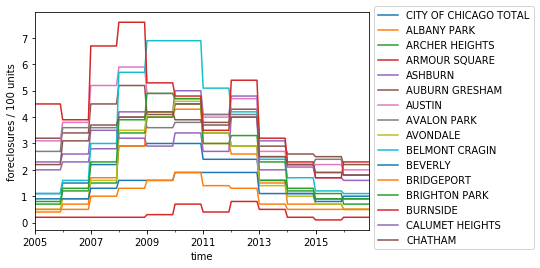

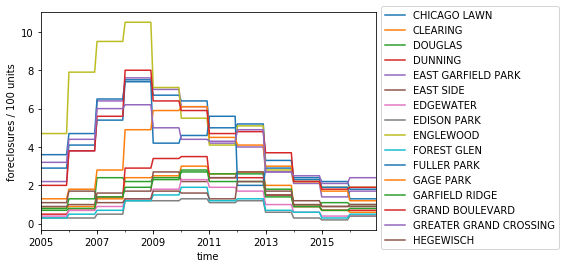

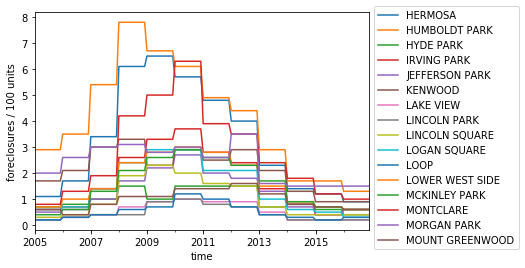

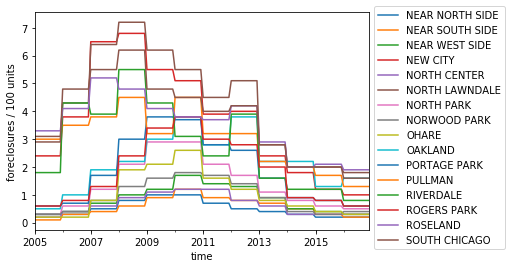

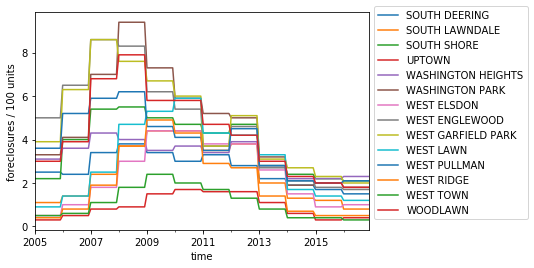

In [7]:
cols_per_plot = 16
for i in range(len(foreclosure_timeseries_annual.columns)//cols_per_plot+1):
    cols_offset = cols_per_plot * i
    cols_to_plot = range(cols_offset,  min(len(foreclosure_timeseries_annual.columns), cols_offset + cols_per_plot))
    foreclosure_timeseries_annual[foreclosure_timeseries_annual.columns[cols_to_plot]].plot().legend(bbox_to_anchor=(1, 1.05))
    plt.ylabel('foreclosures / 100 units')
plt.show()

# Home prices from Zillow

Here we pull in home prices from Zillow. Because Zillow has these at different neighborhood boundaries than other data sources, we will have to do some work to re-aggregate these to the desired boundaries. Also included here is a look at their foreclosure data. The reason we opted to use the alternative source above is because it had better coverage of the city, even though Zillow had more history.

## How do the neighborhoods compare?

Generally, the Zillow neighborhoods are more granular than those on the Chicago Data Portal. Furthermore, it doesn't look like each Zillow neighborhood is a strict subset of exactly one Chicago Data Portal neighborhood, though it seems pretty close. Using the Zillow neighborhoods as a starting point to interpolate the Zillow data will almost certainly yield better results than using Zip codes.

In [8]:
cdp_geo = gpd.read_file('./data/chicago_commarea_geo_data.json')
zillow_geo_IL = gpd.read_file('./data/ZillowNeighborhoods-IL.dbf')
zillow_geo = zillow_geo_IL[zillow_geo_IL['City'] == 'Chicago']

# ensure using same projection
cdp_geo.crs = {'init': 'epsg:4326'}
zillow_geo.crs = {'init': 'epsg:4326'}

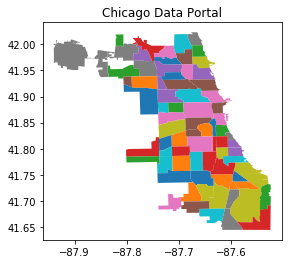

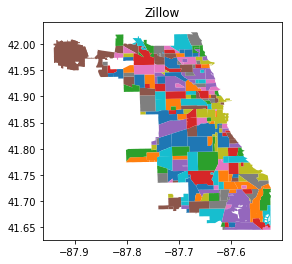

In [9]:
cdp_geo.plot(column='community')
plt.title('Chicago Data Portal')
zillow_geo.plot(column='Name')
plt.title('Zillow')
plt.show()

## Neighborhood Intersection Matrix

We now compute the area overlap of the Zillow and Chicago Data Portal boundaries. These are the bases for weighting data from Zillow to produce estimates at the Chicago Data Portal level. The algebra is...

* Extensive variables (like outright foreclosures): Percent of Zillow area in CDP neighborhood * Zillow Extensive #
* Intensive variables (like cost per square foot or foreclosure rate): Sum of (Area of CDP neighborhood covered by Zillow area * Zillow intensive #) / Sum of (Area of CDP neighborhood covered by Zillow) 

Below we represent the sparse intersection matrix in a tall datadrame with associated values relevant to the aggregations listed above.

In [10]:
neighb_intersects = gpd.sjoin(cdp_geo, zillow_geo, how='inner', op='intersects').set_index('index_right')\
    .join(zillow_geo, rsuffix='_zillow')[['community', 'Name_zillow', 'RegionID_zillow', 'geometry', 'geometry_zillow']]\
    .reset_index(drop=True)\
    .rename(columns = {'geometry' : 'geometry_cdp'})

In [11]:
neighb_intersects['area_cdp'] = neighb_intersects['geometry_cdp'].map(lambda polygon: polygon.area)
neighb_intersects['area_zillow'] = neighb_intersects['geometry_zillow'].map(lambda polygon: polygon.area)
neighb_intersects['geometry_inter'] = neighb_intersects\
    .apply(lambda row: row['geometry_cdp'].intersection(row['geometry_zillow']), axis = 1)
neighb_intersects['area_inter'] = neighb_intersects['geometry_inter'].map(lambda polygon: polygon.area)
neighb_intersects['pct_zillow_in_cdp'] = neighb_intersects['area_inter'] / neighb_intersects['area_zillow']

In [12]:
neighb_intersects.head()

,community,Name_zillow,RegionID_zillow,geometry_cdp,geometry_zillow,area_cdp,area_zillow,geometry_inter,area_inter,pct_zillow_in_cdp
0,WEST TOWN,Wicker Park,7930,(POLYGON ((-87.65686079759237 41.9107845095737...,POLYGON ((-87.66743176018612 41.90457224446712...,0.001286,0.000143,POLYGON ((-87.66743176018612 41.90457224446712...,1.426340e-04,1.000000
1,LINCOLN SQUARE,Ravenswood,33597,(POLYGON ((-87.6744075678037 41.97610340441675...,POLYGON ((-87.66746751104743 41.96890188491437...,0.000720,0.000398,POLYGON ((-87.67440554101975 41.97605398172963...,2.981291e-04,0.748945
2,NORTH PARK,Ravenswood,33597,(POLYGON ((-87.70690177438968 41.9830804665430...,POLYGON ((-87.66746751104743 41.96890188491437...,0.000709,0.000398,POLYGON ((-87.70424126899978 41.97413557617348...,2.585139e-08,0.000065
3,ALBANY PARK,Ravenswood,33597,(POLYGON ((-87.70403771340908 41.9735515829861...,POLYGON ((-87.66746751104743 41.96890188491437...,0.000540,0.000398,(POLYGON ((-87.70403771340908 41.9735515829861...,1.634991e-07,0.000411
4,UPTOWN,Ravenswood,33597,(POLYGON ((-87.64102430213292 41.9548028055325...,POLYGON ((-87.66746751104743 41.96890188491437...,0.000657,0.000398,POLYGON ((-87.66653732509738 41.96162750677766...,9.962375e-05,0.250270


Note that some of the intersection areas are very very tiny. This is likely due to minor differences in how the neighborhood boundaries were specified (such as differences in the shape of a coastline based on the fidelity of the CDP and Zillow teams). These shouldn't meaningfully affect our analysis outputs when interpolating and are not worth attempting to prune out.

Lets take a quick look at how often the neighborhoods fully encapsulate individual zillow neighborhoods. We'll filter out everything with less than a 1% fraction. It looks pretty good ... we are not cutting our Zillow data in half very often; in general the Zillow data lies entirely within the CDP neighborhood.

This means when summing extensive variables we will get very accurate / representative results without assumptions. However, for intensive variables, we remain assuming that housing density and activity is distributed uniformly within a neighborhood.

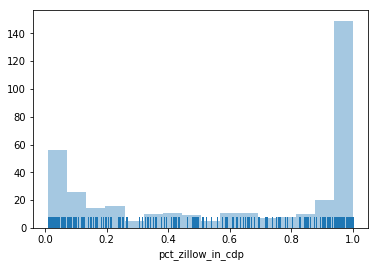

In [13]:
sns.distplot(neighb_intersects[neighb_intersects['pct_zillow_in_cdp'] > 1e-2]['pct_zillow_in_cdp'], 
             bins = 16, kde = False, rug = True)
plt.show()

## Associating home price information to neighborhoods

Now we load the Zillow foreclosure per 10k homes (intensive) and home price per square foot (intensive) information. Both are intensive, but should we want to include extensive aggregations we could do so in the future. We find the pricing data to be acceptable in terms of coverage, but the foreclosure data from Zillow is too sparse for practical use.

Here we will keep housing prices nominal. In a later analysis, inflation adjustments will be applied.

In [14]:
zillow_foreclosure_rate = pd.read_csv('./data/zillow_foreclosure_rate_neighborhood.csv')
zillow_price_per_sq_foot = pd.read_csv('./data/zillow_price_per_sq_foot.csv')

In [15]:
zillow_foreclosure_rate.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1998-01,1998-02,1998-03,...,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07
0,403117,Little Village,Chicago,IL,Chicago,Cook,80,3.0667,3.7505,1.8995,...,NaN,NaN,NaN,NaN,1.9562,NaN,NaN,NaN,NaN,NaN
1,403169,West Rogers Park,Chicago,IL,Chicago,Cook,88,2.5421,2.5992,2.6250,...,0.4319,NaN,1.4442,1.3534,1.1186,0.8850,0.8779,0.4387,0.5568,NaN
2,403120,South Austin,Chicago,IL,Chicago,Cook,128,6.2656,3.3616,2.5039,...,NaN,NaN,NaN,NaN,NaN,1.2127,NaN,1.7891,NaN,NaN
3,403295,Lake View East,Chicago,IL,Chicago,Cook,246,3.9557,2.5169,2.7607,...,0.3542,0.6267,0.3714,NaN,NaN,NaN,NaN,0.7041,1.1977,0.7046
4,403146,Back of the Yards,Chicago,IL,Chicago,Cook,252,8.4905,4.9528,4.4141,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.8735,NaN


In [16]:
zillow_price_per_sq_foot.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07
0,269592,Logan Square,Chicago,IL,Chicago,Cook,53,105.0,104.0,103.0,...,263,266,269,272,274,274,273,273,273,274
1,403117,Little Village,Chicago,IL,Chicago,Cook,73,84.0,84.0,84.0,...,139,141,142,144,146,148,148,148,147,146
2,403169,West Rogers Park,Chicago,IL,Chicago,Cook,80,105.0,104.0,102.0,...,216,217,219,221,222,223,221,220,218,218
3,269566,Albany Park,Chicago,IL,Chicago,Cook,109,115.0,115.0,114.0,...,237,238,240,243,245,247,248,248,249,249
4,269568,Archer Heights,Chicago,IL,Chicago,Cook,114,91.0,91.0,91.0,...,152,153,154,155,157,159,160,161,161,160


### Data coverage

We don't have data for every Zillow neighborhood, but we do have data for every target community / neighborhood. This means that in select neighborhoods, we might have slight bias toward the sub-areas represented. Note, however, that much of the city is not covered in Zillow's foreclosures data. For this reason we will use an alternative foreclosures source.

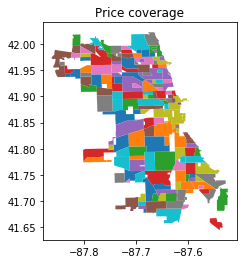

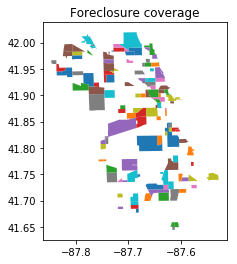

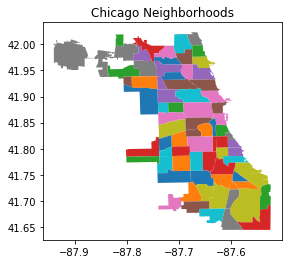

In [17]:
price_coverage = pd.merge(zillow_geo, zillow_price_per_sq_foot, left_on='Name', right_on='RegionName')

foreclosure_coverage = pd.merge(zillow_geo, zillow_foreclosure_rate, left_on='Name', right_on='RegionName')

# using Name here because it does not need cleaning (RegionID does for some reason)
price_coverage.plot(column='Name')
plt.title('Price coverage')
foreclosure_coverage.plot(column='Name')
plt.title('Foreclosure coverage')
cdp_geo.plot(column='community')
plt.title('Chicago Neighborhoods')
plt.show()

### Joining and aggregating intensive data

Here we process the foreclosure and unit housing price information to the target Chicago Data Portal level. 

In [18]:
def process_intensive_zillow_timeseries(data_df, inter_df):
    # idnentify time series columns
    time_cols = [ col for col in data_df.columns\
                    if len(col) == 7 and col[4] == '-' and col[:4].isdigit() and col[5:].isdigit() ]
    
    # specify and copy dataframes to avoid side effects
    data_df_for_join = data_df[['RegionID', 'RegionName'] + time_cols].copy()
    inter_df_for_join = inter_df.copy()
    data_df_for_join['RegionID'] = data_df_for_join['RegionID'].map(int)
    inter_df_for_join['RegionID_zillow'] = inter_df_for_join['RegionID_zillow'].map(int)
    
    # merge to identify overlap
    comb_df = pd.merge(inter_df_for_join, data_df_for_join, left_on='RegionID_zillow', right_on='RegionID', how='inner')
    
    # calculate weighted values -- weights are area of chicago neighborhood represented by zillow data
    comb_df_weighted = comb_df.copy()
    comb_df_weighted['weight'] = comb_df_weighted['area_inter']
    for time in time_cols:
        comb_df_weighted[time] = comb_df_weighted['weight'] * comb_df_weighted[time]
        
    # aggregate and average
    agg_df = comb_df_weighted.groupby('community')[['weight'] + time_cols].sum()
    avg_per_neighborhood = agg_df.copy()
    for time in time_cols:
        avg_per_neighborhood[time] /= avg_per_neighborhood['weight']
        
    # format as a time series
    price_time_series = avg_per_neighborhood.transpose().drop('weight')
    price_time_series.index = price_time_series.index.map(lambda mo: pd.Period(mo, freq = 'M'))
    price_time_series.index.names = ['time']
    return price_time_series

In [19]:
price_timeseries_monthly = process_intensive_zillow_timeseries(zillow_price_per_sq_foot, neighb_intersects)

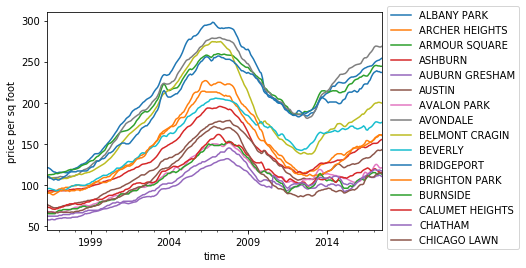

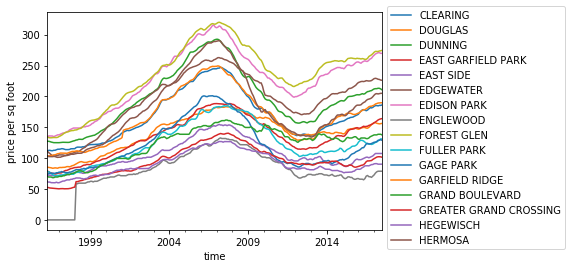

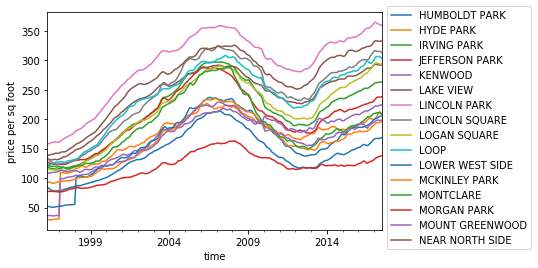

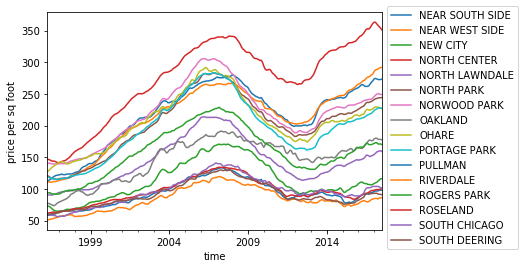

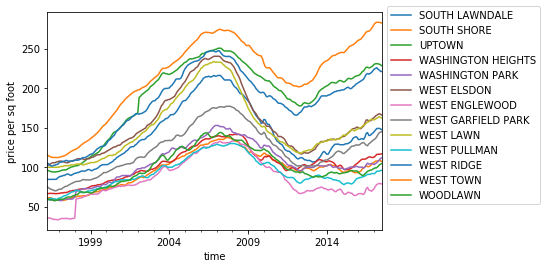

In [20]:
cols_per_plot = 16
for i in range(len(price_timeseries_monthly.columns)//cols_per_plot+1):
    cols_offset = cols_per_plot * i
    cols_to_plot = range(cols_offset,  min(len(price_timeseries_monthly.columns), cols_offset + cols_per_plot))
    price_timeseries_monthly[price_timeseries_monthly.columns[cols_to_plot]].plot().legend(bbox_to_anchor=(1, 1.05))
    plt.ylabel('price per sq foot')
plt.show()